<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Using meta_analysis data with bigger taining data.

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. Modified R2 score
5. Gene normalization

TODO:
  - Normalize all the data in the same way.
  - Before normalizign the more_data, take care of data with only zeros for the gene expression.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')
bulk_path = Path.home()/'Downloads/data'

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
loss_func = F.mse_loss

In [5]:
class TimeLayer(nn.Module):
    def __init__(self, range = 24):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [6]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [7]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [8]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

<img src="data/cell_nrm.jpg" alt="Cell normalization" width="400">

In [9]:
def nrm_genes(df):
    """Assuming genes on cols cells on rows."""
    cell_divided = df.div(df.sum(axis=1), axis=0)
    return (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)

In [10]:
bulk = pd.read_csv(path/'sc_RNA_ct.csv', low_memory=False)
bulk = bulk.set_index('Unnamed: 0').T
bulk = nrm_genes(bulk)
bulk

Unnamed: 0,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Co2,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb
AAACAGCCAGCAATAA.8,-0.049673,-0.04268,-0.124963,-0.489307,-0.363687,-0.633744,-0.048407,-0.626202,-0.174223,-0.312544,...,-0.331006,-0.146142,-0.368729,-0.094769,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.000030
AAACGCGCAGTATGTT.8,-0.049673,-0.04268,-0.124963,-0.489307,2.078659,-0.633744,-0.048407,-0.626202,1.304845,-0.312544,...,-0.104301,-0.146142,-0.190708,-0.086019,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213
AAAGCGGGTGCATCGG.8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,0.477558,-0.168903,-0.312544,...,-0.462332,-0.146142,-0.264324,-0.092338,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213
AAAGGACGTAAGGTTT.8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,0.512518,-0.312544,...,0.010841,-0.146142,-0.286073,0.218951,-0.293294,-0.212751,-0.432418,1.039197,-0.118702,-0.041078
AAAGGAGCAACCGCCA.8,-0.049673,-0.04268,-0.124963,-0.489307,1.023501,-0.633744,-0.048407,-0.626202,0.480769,-0.312544,...,-0.462332,-0.146142,-0.107936,-0.140863,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.048753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCAAGTCTACTAAG.2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.076857,-0.146142,0.133536,-0.486173,-0.293294,-0.212751,0.315597,-0.324576,-0.118702,0.193742
TACCGTTGTTACGCAA.2,-0.049673,-0.04268,-0.124963,-0.489307,0.426962,-0.633744,-0.048407,-0.626202,-1.031017,3.542551,...,0.499527,-0.146142,-0.220086,0.230510,-0.293294,3.425442,0.189745,-0.324576,-0.118702,0.091455
TCCATCATCAGGTTTA.2,-0.049673,-0.04268,-0.124963,-0.489307,0.745681,1.589905,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.065406,-0.146142,-0.160166,0.105327,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.837817
TCGTTAGCAGTAGGAT.2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,2.106065,-0.146142,-0.471852,0.279314,-0.293294,-0.212751,0.564378,-0.324576,-0.118702,-0.414213


In [11]:
bulk.mean(axis=0), bulk.std(axis=0)

(Unnamed: 0
 Xkr4      -9.370579e-16
 Rp1        1.494557e-15
 Sox17      5.149340e-15
 Mrpl15     1.464738e-15
 Lypla1    -6.293459e-15
                ...     
 mt-Nd4l   -1.640594e-14
 mt-Nd4     3.022342e-14
 mt-Nd5     6.536581e-15
 mt-Nd6     1.068012e-15
 mt-Cytb   -3.061406e-14
 Length: 16368, dtype: float64,
 Unnamed: 0
 Xkr4       1.0
 Rp1        1.0
 Sox17      1.0
 Mrpl15     1.0
 Lypla1     1.0
           ... 
 mt-Nd4l    1.0
 mt-Nd4     1.0
 mt-Nd5     1.0
 mt-Nd6     1.0
 mt-Cytb    1.0
 Length: 16368, dtype: float64)

In [12]:
bulk_tz = pd.read_csv(path/'sc_RNA_ZT.csv', low_memory=False).set_index('Unnamed: 0')
bulk_tz

,ZT
Unnamed: 0,
AAACAGCCAGCAATAA-8,ZT18
AAACGCGCAGTATGTT-8,ZT18
AAAGCGGGTGCATCGG-8,ZT18
AAAGGACGTAAGGTTT-8,ZT18
AAAGGAGCAACCGCCA-8,ZT18
...,...
GTCCAAGTCTACTAAG-2,ZT06
TACCGTTGTTACGCAA-2,ZT06
TCCATCATCAGGTTTA-2,ZT06


In [13]:
bulk.index = bulk.index.str.replace('.', '-')
bulk['code'] = bulk_tz
bulk['code'] = bulk.loc[:,'code'].str[-2:].map(float)
bulk

Unnamed: 0,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,code
AAACAGCCAGCAATAA-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.363687,-0.633744,-0.048407,-0.626202,-0.174223,-0.312544,...,-0.146142,-0.368729,-0.094769,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.000030,18.0
AAACGCGCAGTATGTT-8,-0.049673,-0.04268,-0.124963,-0.489307,2.078659,-0.633744,-0.048407,-0.626202,1.304845,-0.312544,...,-0.146142,-0.190708,-0.086019,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,18.0
AAAGCGGGTGCATCGG-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,0.477558,-0.168903,-0.312544,...,-0.146142,-0.264324,-0.092338,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.414213,18.0
AAAGGACGTAAGGTTT-8,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,0.512518,-0.312544,...,-0.146142,-0.286073,0.218951,-0.293294,-0.212751,-0.432418,1.039197,-0.118702,-0.041078,18.0
AAAGGAGCAACCGCCA-8,-0.049673,-0.04268,-0.124963,-0.489307,1.023501,-0.633744,-0.048407,-0.626202,0.480769,-0.312544,...,-0.146142,-0.107936,-0.140863,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,-0.048753,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCAAGTCTACTAAG-2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.146142,0.133536,-0.486173,-0.293294,-0.212751,0.315597,-0.324576,-0.118702,0.193742,6.0
TACCGTTGTTACGCAA-2,-0.049673,-0.04268,-0.124963,-0.489307,0.426962,-0.633744,-0.048407,-0.626202,-1.031017,3.542551,...,-0.146142,-0.220086,0.230510,-0.293294,3.425442,0.189745,-0.324576,-0.118702,0.091455,6.0
TCCATCATCAGGTTTA-2,-0.049673,-0.04268,-0.124963,-0.489307,0.745681,1.589905,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.146142,-0.160166,0.105327,-0.293294,-0.212751,-0.432418,-0.324576,-0.118702,0.837817,6.0
TCGTTAGCAGTAGGAT-2,-0.049673,-0.04268,-0.124963,-0.489307,-0.912213,-0.633744,-0.048407,-0.626202,-1.031017,-0.312544,...,-0.146142,-0.471852,0.279314,-0.293294,-0.212751,0.564378,-0.324576,-0.118702,-0.414213,6.0


### Bulk + scRNA-seq

In [14]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [15]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [17]:
bulk_data = nrm_genes(raw_bulk_data.set_index('ID').T)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [18]:
gro = nrm_genes(raw_gro.set_index('ID').T)
nascent = nrm_genes(raw_nascent.set_index('ID').T)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [19]:
bulk_data

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
ZT2_1,1.082428,1.717867,-1.003875,-0.669267,0.816101,0.471805,-1.540975,0.119574,-0.233131,0.838950,...,2.747362,-0.460841,1.917347,0.127566,-0.799820,-0.455745,0.146379,-0.576091,-0.564002,2
ZT6_1,0.087753,0.330009,0.187294,-1.181104,-0.846484,-0.303438,-0.654141,-1.137337,-0.525248,-1.029984,...,-0.795557,0.173786,-0.709879,0.108785,0.712511,-1.142857,-1.223899,1.112721,0.012469,6
ZT10_1,-0.816346,-1.057083,0.371357,-0.641244,-1.933474,-1.821166,0.745540,-1.019232,-0.542662,-1.163239,...,0.210171,0.221001,-0.251049,-1.652786,-0.313158,-0.071726,1.834361,-2.024334,-1.792529,10
ZT14_1,-0.720197,-0.938543,1.729306,0.761443,-0.105645,-0.403631,0.799266,-0.165066,-0.295312,-0.428135,...,0.554481,1.596180,0.494570,0.966976,0.040629,-0.017075,-0.643337,1.521204,1.411758,14
ZT18_1,0.209483,-0.409910,0.342193,1.282113,0.381770,0.574437,0.963199,0.562810,0.010501,1.133141,...,-0.413376,-1.200138,0.904244,-0.121357,1.189584,0.706100,0.058198,-0.260754,0.365997,18
ZT22_1,0.964961,0.638207,-0.978263,0.952341,1.044113,1.314212,0.053336,1.354167,0.166896,1.220084,...,0.232522,1.487383,-1.045996,-0.325668,0.554796,-0.962842,-0.270750,0.215825,1.505933,22
ZT2_2,0.989394,1.513236,-1.954013,-1.001980,0.653880,1.008998,-1.513408,0.063987,-0.301113,0.527549,...,-0.975348,0.177286,0.747333,0.032291,-1.560521,-0.145595,-0.202777,-0.988569,-0.277518,2
ZT6_2,-0.459597,-0.288067,-0.071178,-1.267921,-0.483437,-0.590565,-0.910870,-1.159240,-0.525305,-1.141050,...,-0.702303,0.120681,-0.215092,1.631189,1.269801,1.666237,-0.644183,1.237696,1.116562,6
ZT10_2,-2.227564,-1.186357,0.848500,-0.403784,-1.300503,-1.300770,0.118115,-1.101337,-0.492871,-1.113219,...,-0.038684,-0.679336,-0.473697,-0.482347,0.341780,0.661954,0.250987,-0.473569,0.287446,10
ZT14_2,-0.567742,-1.055971,0.951135,0.417576,-0.312159,-0.543626,1.341477,-0.285257,-0.405983,-0.650162,...,0.079044,-1.345802,-0.104850,-0.336308,-1.907668,-1.835495,0.130619,-0.182400,-0.289401,14


We only want the intersection of training and test data.

In [20]:
intersecting_genes = bulk_data.columns.intersection(bulk.columns)
df = bulk.loc[:,intersecting_genes]

## Adding more datasets

See meta_analysis for more data.

In [21]:
path = Path('data/scRNA_datasets')
more_data = pd.read_csv(path/'tpm.by_sample.txt', sep='\t', low_memory=False).dropna(how='any').T.drop(index='Name')
more_data.columns = more_data.loc['Symbol']
more_data = more_data.drop(index='Symbol')
more_data = more_data.astype('float64')

Getting rid of genes that don't express anything.

In [22]:
# Checking which ones are in training data
zero_cols = more_data.loc[:,more_data.sum(axis=0) == 0].columns
len(set(zero_cols).intersection(df.columns))

0

In [23]:
more_data = more_data.drop(zero_cols, axis=1)
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Eef1akmt4,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902
GSM2046160,0.047856,0.043026,0.013747,0.000000,0.017114,0.184585,0.0,0.000000,0.000000,8.55776,...,4.80793,0.585986,0.043350,0.000000,0.0,0.000000,0.029685,2.69082,0.0,0.000000
GSM2046184,0.000000,0.017274,0.012649,0.000000,0.000000,0.225739,0.0,0.000000,0.084449,4.54988,...,4.70429,0.682593,0.038878,0.000000,0.0,0.017092,0.031688,2.20585,0.0,0.000000
GSM2046157,0.011696,0.012144,0.029259,0.000000,0.000000,0.246204,0.0,0.000000,0.000000,8.24781,...,3.84295,0.521939,0.045233,0.119700,0.0,0.000000,0.000000,2.56285,0.0,0.015267
GSM2046183,0.038796,0.035352,0.012449,0.000000,0.000000,0.207048,0.0,0.000000,0.000000,8.40232,...,4.45069,0.404564,0.017379,0.170666,0.0,0.000000,0.009918,2.47665,0.0,0.000000
GSM2046155,0.000000,0.025837,0.080033,0.000000,0.000000,0.157396,0.0,0.000000,0.619891,11.43590,...,4.87733,0.367240,0.088547,0.134558,0.0,0.000000,0.007446,2.71046,0.0,0.011883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.000000,0.035516,0.215311,0.000000,0.000000,0.000000,0.0,0.130749,0.316231,0.00000,...,8.84043,0.794336,0.318900,0.000000,0.0,0.000000,0.023322,1.85593,0.0,0.000000
GSM6610724,0.000000,0.078964,0.200141,0.000000,0.000000,0.806385,0.0,0.000000,0.000000,0.00000,...,8.37920,0.752421,0.165695,0.110278,0.0,0.000000,0.070138,1.70914,0.0,0.000000
GSM6610752,0.000000,0.043414,0.228735,0.000000,0.000000,0.447329,0.0,0.000000,0.405717,0.00000,...,8.78542,0.796097,0.265712,0.000000,0.0,0.000000,0.054193,2.71010,0.0,0.000000
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.000000,1.184650,0.0,0.000000,0.829571,1.58835,...,7.12422,0.715682,0.034111,0.276602,0.0,0.000000,0.047538,1.66776,0.0,0.000000


In [24]:
more_data = nrm_genes(more_data)
more_data.mean(axis=0), more_data.std(axis=0)

(Symbol
 Gm14820    -2.856659e-16
 Flicr       1.852989e-16
 Gm13449     3.932378e-16
 C79798     -6.583086e-16
 Nron       -1.064892e-16
                 ...     
 Rpsa-ps3    3.448681e-16
 Gm14634    -7.021958e-16
 Zkscan7    -2.554083e-15
 Agbl1       2.256913e-16
 Gm8902     -2.688948e-16
 Length: 32904, dtype: float64,
 Symbol
 Gm14820     1.0
 Flicr       1.0
 Gm13449     1.0
 C79798      1.0
 Nron        1.0
            ... 
 Rpsa-ps3    1.0
 Gm14634     1.0
 Zkscan7     1.0
 Agbl1       1.0
 Gm8902      1.0
 Length: 32904, dtype: float64)

In [25]:
meta_data = pd.read_csv(path/'sample_metadata.txt', sep='\t', index_col='sample', low_memory=False)
more_data['code'] = meta_data['time']
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902,code
GSM2046160,0.259269,-0.157117,-0.246090,-0.136791,1.989747,-0.360068,-0.058182,-0.171698,-0.470116,2.019621,...,-0.495987,0.179397,-0.319751,-0.045089,-0.227785,-0.340332,0.049125,-0.108363,-0.133167,22.0
GSM2046184,-0.058396,-0.269264,-0.248887,-0.136791,-0.098070,-0.307829,-0.058182,-0.171698,-0.410231,0.846156,...,-0.304115,0.118501,-0.319751,-0.045089,0.115119,-0.308742,-0.296044,-0.108363,-0.133167,22.0
GSM2046157,0.019232,-0.291584,-0.206713,-0.136791,-0.098070,-0.281764,-0.058182,-0.171698,-0.470116,1.928629,...,-0.623569,0.204906,0.920292,-0.045089,-0.227785,-0.810639,-0.042041,-0.108363,0.282452,10.0
GSM2046183,0.198919,-0.190655,-0.249412,-0.136791,-0.098070,-0.331724,-0.058182,-0.171698,-0.470116,1.972117,...,-0.857706,-0.173566,1.447035,-0.045089,-0.227785,-0.653634,-0.104544,-0.108363,-0.133167,18.0
GSM2046155,-0.058396,-0.231989,-0.077843,-0.136791,-0.098070,-0.394689,-0.058182,-0.171698,-0.030527,2.861126,...,-0.931528,0.792993,1.073994,-0.045089,-0.227785,-0.692702,0.062562,-0.108363,0.190277,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,-0.058396,-0.188282,0.271110,-0.136791,-0.098070,-0.594739,-0.058182,5.690522,-0.243579,-0.485181,...,-0.065659,3.965212,-0.319751,-0.045089,-0.227785,-0.437478,-0.531234,-0.108363,-0.133167,13.5
GSM6610724,-0.058396,0.003074,0.232662,-0.136791,-0.098070,0.441533,-0.058182,-0.171698,-0.470116,-0.485181,...,-0.148572,1.865558,0.835159,-0.045089,-0.227785,0.312584,-0.635527,-0.108363,-0.133167,7.5
GSM6610752,-0.058396,-0.154137,0.303737,-0.136791,-0.098070,-0.022147,-0.058182,-0.171698,-0.180364,-0.485181,...,-0.067015,3.224430,-0.319751,-0.045089,-0.227785,0.053816,0.075979,-0.108363,-0.133167,19.5
GSM6610726,0.051729,-0.152073,0.446019,2.480244,-0.098070,0.923370,-0.058182,-0.171698,0.123017,-0.016574,...,-0.226513,0.057596,2.568907,-0.045089,-0.227785,-0.051476,-0.668614,-0.108363,-0.133167,7.5


In `more_data`, there are duplicate genes, such as '4930594M22Rik'.

In [26]:
more_data.columns.duplicated().sum()

27

In [27]:
more_data = more_data.loc[:, ~more_data.columns.duplicated(keep='first')]

In [28]:
more_data.columns.duplicated().sum()

0

## Changing the testing bulk data

We also want the shape of test data to match the shape of our train data.

In [29]:
len(intersecting_genes)

9335

In [30]:
bulk.loc[:,intersecting_genes].shape

(26068, 9335)

In [31]:
def make_df2(ds):
    """Assuming the dataset includes all the genes of intersecting_genes"""
    return ds.reindex(columns=intersecting_genes, fill_value=0)

In [32]:
nascent_df = make_df2(nascent)
gro_df = make_df2(gro)
rna_df = make_df2(bulk_data)
more_df = make_df2(more_data)

## Using Pytorch

In [33]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-1]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_18788/705046130.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [34]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [35]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [36]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([20855, 1]), torch.Size([5213, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [37]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 9334]), torch.Size([128, 1]))

In [38]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [39]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
more_dl = make_dl(more_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl, 'more': more_dl}

/tmp/ipykernel_18788/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_18788/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_18788/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_18788/2507783698.py:2: Fu

Changing the metric to R2Score.

In [40]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [41]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [42]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [43]:
get_model()(xb).shape

torch.Size([128, 1])

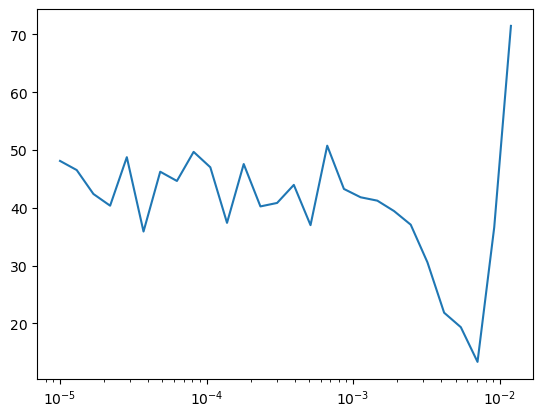

In [44]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.756,11.049,0,True,00:04
0.856,6.490,0,False,00:01
0.952,2.138,1,True,00:04
0.864,6.167,1,False,00:01


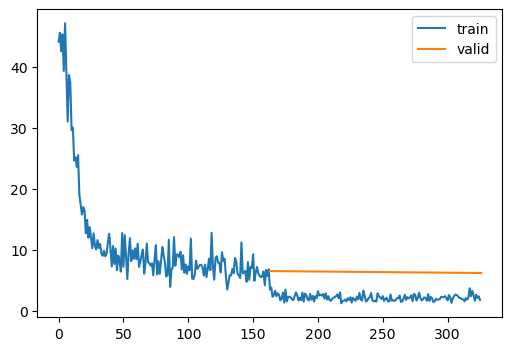

In [45]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [46]:
from functools import partial

In [47]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [56]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    preds = {}
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        preds[dl_name] = torch.concat([ap, cps[0].all_targs], dim=1)  # Saving predictions
        print('result: ', metric.compute())
    return preds

In [57]:
nlearn = 2

Training models


TimeR2Score,loss,epoch,train,time
0.753,11.184,0,True,00:04
0.840,7.261,0,False,00:01
0.951,2.161,1,True,00:04
0.865,6.106,1,False,00:01


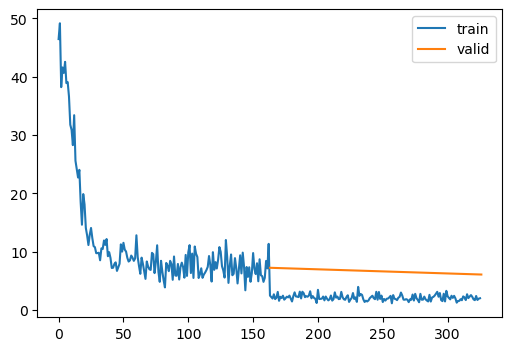

TimeR2Score,loss,epoch,train,time
0.743,11.530,0,True,00:04
0.851,6.737,0,False,00:01
0.951,2.191,1,True,00:04
0.860,6.351,1,False,00:01


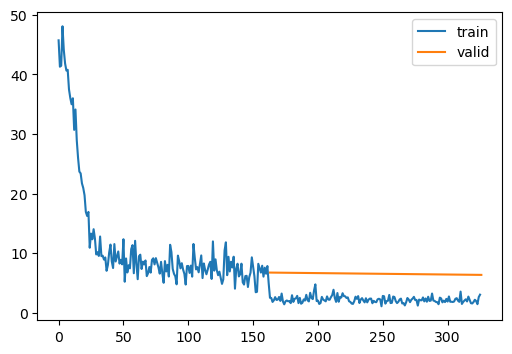

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.329,61.478,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.451,58.617,0,False,00:00


Inference on nascent
		preds, targs
tensor([[19.4353,  0.0000],
        [ 2.7496,  4.0000],
        [10.3796,  8.0000],
        [ 4.4858, 12.0000],
        [11.1948, 16.0000],
        [23.5021, 20.0000],
        [ 1.6704,  0.0000],
        [ 0.2539,  4.0000],
        [20.4622,  8.0000],
        [ 9.9994, 12.0000],
        [23.0952, 16.0000],
        [23.8928, 20.0000]])
result:  tensor(0.3941)


TimeR2Score,loss,epoch,train,time
0.600,29.488,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.591,33.339,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 3.9025,  1.0000],
        [ 3.3403,  4.0000],
        [ 4.2341,  7.0000],
        [ 9.3132, 10.0000],
        [16.4936, 13.0000],
        [ 1.9504, 16.0000],
        [23.5431, 19.0000],
        [23.5745, 22.0000]])
result:  tensor(0.5997)


TimeR2Score,loss,epoch,train,time
0.653,36.068,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.580,34.506,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 8.4949,  2.0000],
        [ 4.5919,  6.0000],
        [ 8.7317, 10.0000],
        [14.5159, 14.0000],
        [23.6273, 18.0000],
        [23.5781, 22.0000],
        [ 2.9331,  2.0000],
        [ 9.1874,  6.0000],
        [ 9.7112, 10.0000],
        [10.9047, 14.0000],
        [10.8486, 18.0000],
        [ 5.6524, 22.0000]])
result:  tensor(0.6239)


TimeR2Score,loss,epoch,train,time
0.693,153.461,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.699,151.115,0,False,00:03


Inference on more
		preds, targs
tensor([[ 5.5461, 22.0000],
        [ 4.9334, 22.0000],
        [ 8.1373, 10.0000],
        ...,
        [23.3154, 19.5000],
        [11.6384,  7.5000],
        [17.2510, 13.5000]])
result:  tensor(0.6972)


In [50]:
preds = ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [58]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [59]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

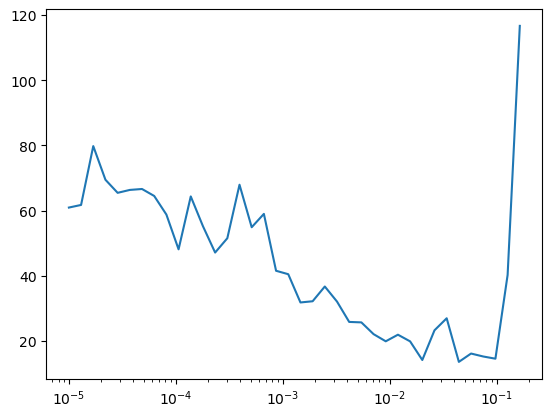

In [58]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.776,10.584,0,True,00:06
0.849,6.757,0,False,00:01
0.868,6.013,1,True,00:05
0.863,6.192,1,False,00:01
0.931,3.095,2,True,00:06
0.884,5.464,2,False,00:01
0.962,1.704,3,True,00:05
0.887,5.267,3,False,00:01


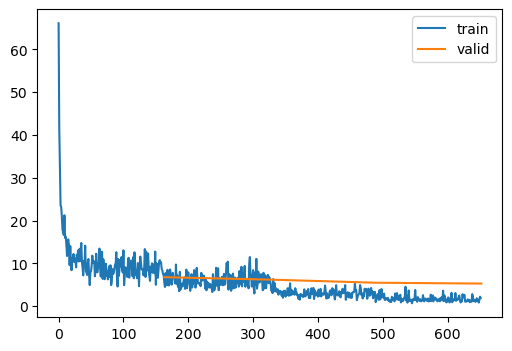

TimeR2Score,loss,epoch,train,time
0.771,10.814,0,True,00:05
0.840,7.465,0,False,00:01
0.865,6.206,1,True,00:05
0.869,5.921,1,False,00:01
0.928,3.249,2,True,00:05
0.890,5.119,2,False,00:01
0.962,1.692,3,True,00:05
0.893,5.023,3,False,00:01


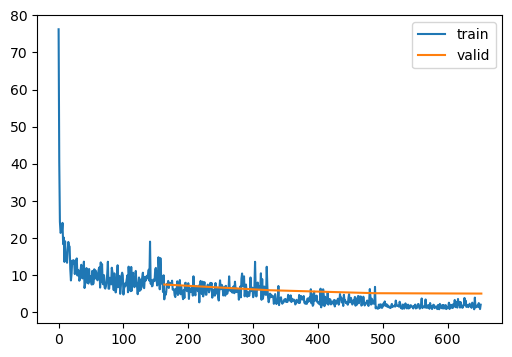

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.532,24.499,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.642,39.868,0,False,00:00


Inference on nascent
		preds, targs
tensor([[15.2260,  0.0000],
        [ 3.2067,  4.0000],
        [10.1139,  8.0000],
        [ 5.6762, 12.0000],
        [11.4756, 16.0000],
        [21.7766, 20.0000],
        [ 0.9863,  0.0000],
        [ 1.1770,  4.0000],
        [13.4896,  8.0000],
        [ 7.9602, 12.0000],
        [19.8449, 16.0000],
        [22.5939, 20.0000]])
result:  tensor(0.6025)


TimeR2Score,loss,epoch,train,time
0.665,15.824,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.775,10.611,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.4887,  1.0000],
        [ 5.6196,  4.0000],
        [ 6.0203,  7.0000],
        [ 9.5051, 10.0000],
        [13.6654, 13.0000],
        [ 6.3249, 16.0000],
        [20.6841, 19.0000],
        [22.5433, 22.0000]])
result:  tensor(0.7269)


TimeR2Score,loss,epoch,train,time
0.420,57.035,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.553,24.875,0,False,00:00


Inference on rna
		preds, targs
tensor([[12.8039,  2.0000],
        [ 5.6912,  6.0000],
        [ 9.7162, 10.0000],
        [15.5641, 14.0000],
        [23.1308, 18.0000],
        [21.6465, 22.0000],
        [ 2.1773,  2.0000],
        [ 8.2543,  6.0000],
        [10.7590, 10.0000],
        [10.4221, 14.0000],
        [ 8.8805, 18.0000],
        [ 7.4585, 22.0000]])
result:  tensor(0.3984)


TimeR2Score,loss,epoch,train,time
0.671,144.654,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.709,141.173,0,False,00:03


Inference on more
		preds, targs
tensor([[ 5.0988, 22.0000],
        [ 5.6239, 22.0000],
        [ 8.8635, 10.0000],
        ...,
        [21.7906, 19.5000],
        [13.7542,  7.5000],
        [15.8863, 13.5000]])
result:  tensor(0.6912)


In [60]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.781,10.415,0,True,00:05
0.844,7.183,0,False,00:01
0.887,5.192,1,True,00:05
0.873,6.018,1,False,00:01
0.943,2.559,2,True,00:06
0.890,5.116,2,False,00:01
0.969,1.386,3,True,00:06
0.892,5.060,3,False,00:01


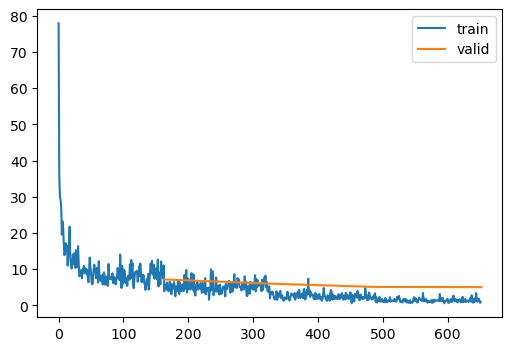

TimeR2Score,loss,epoch,train,time
0.776,10.512,0,True,00:05
0.837,8.260,0,False,00:01
0.890,5.005,1,True,00:05
0.871,5.810,1,False,00:01
0.945,2.457,2,True,00:05
0.888,5.159,2,False,00:01
0.968,1.438,3,True,00:05
0.891,4.956,3,False,00:01


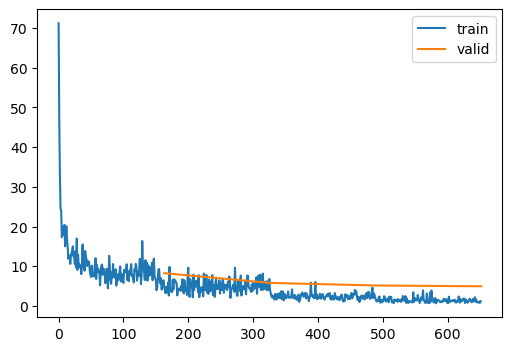

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.773,43.312,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.624,30.953,0,False,00:00


Inference on nascent
		preds, targs
tensor([[17.7636,  0.0000],
        [ 3.9817,  4.0000],
        [ 9.9192,  8.0000],
        [ 6.0511, 12.0000],
        [12.8533, 16.0000],
        [22.0466, 20.0000],
        [ 0.8182,  0.0000],
        [ 1.6556,  4.0000],
        [11.4553,  8.0000],
        [ 8.7225, 12.0000],
        [21.7944, 16.0000],
        [22.7535, 20.0000]])
result:  tensor(0.7106)


TimeR2Score,loss,epoch,train,time
0.551,21.229,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.633,17.318,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.6213,  1.0000],
        [ 8.7269,  4.0000],
        [ 5.7588,  7.0000],
        [ 9.3969, 10.0000],
        [12.9432, 13.0000],
        [ 5.2580, 16.0000],
        [21.2389, 19.0000],
        [22.7261, 22.0000]])
result:  tensor(0.6090)


TimeR2Score,loss,epoch,train,time
0.245,42.636,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.627,35.960,0,False,00:00


Inference on rna
		preds, targs
tensor([[12.8391,  2.0000],
        [ 5.6487,  6.0000],
        [ 9.7574, 10.0000],
        [15.1282, 14.0000],
        [23.4387, 18.0000],
        [21.9533, 22.0000],
        [ 2.2639,  2.0000],
        [ 7.7335,  6.0000],
        [10.3516, 10.0000],
        [ 9.9721, 14.0000],
        [ 9.3071, 18.0000],
        [ 7.5435, 22.0000]])
result:  tensor(0.4025)


TimeR2Score,loss,epoch,train,time
0.687,147.076,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.684,140.612,0,False,00:03


Inference on more
		preds, targs
tensor([[ 5.4580, 22.0000],
        [ 5.6772, 22.0000],
        [ 8.8313, 10.0000],
        ...,
        [22.2747, 19.5000],
        [14.0508,  7.5000],
        [16.5042, 13.5000]])
result:  tensor(0.6856)


In [61]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.771,10.793,0,True,00:05
0.765,10.477,0,False,00:01
0.853,6.861,1,True,00:05
0.854,6.545,1,False,00:01
0.896,4.711,2,True,00:05
0.864,6.382,2,False,00:01
0.938,2.768,3,True,00:05
0.874,6.169,3,False,00:01
0.965,1.535,4,True,00:05
0.886,5.389,4,False,00:01


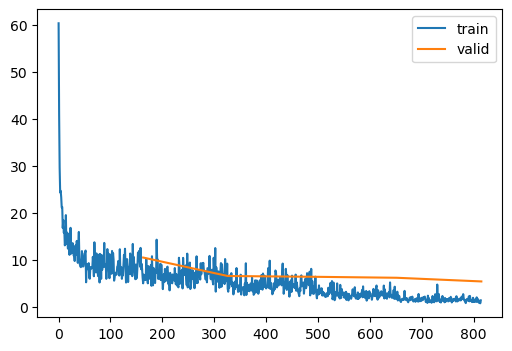

TimeR2Score,loss,epoch,train,time
0.777,10.412,0,True,00:05
0.844,7.152,0,False,00:01
0.857,6.606,1,True,00:05
0.860,6.335,1,False,00:01
0.900,4.576,2,True,00:05
0.877,5.691,2,False,00:01
0.941,2.641,3,True,00:05
0.891,5.173,3,False,00:01
0.965,1.548,4,True,00:05
0.893,5.100,4,False,00:01


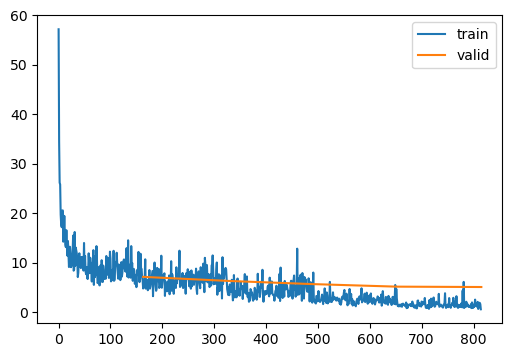

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.739,32.418,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.706,38.361,0,False,00:00


Inference on nascent
		preds, targs
tensor([[17.6108,  0.0000],
        [ 2.8541,  4.0000],
        [ 8.9065,  8.0000],
        [ 5.9999, 12.0000],
        [12.6091, 16.0000],
        [21.4822, 20.0000],
        [ 0.8571,  0.0000],
        [ 1.5828,  4.0000],
        [12.8443,  8.0000],
        [ 8.8008, 12.0000],
        [19.7868, 16.0000],
        [22.2930, 20.0000]])
result:  tensor(0.7276)


TimeR2Score,loss,epoch,train,time
0.661,16.007,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.659,16.125,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 3.6925,  1.0000],
        [ 9.3286,  4.0000],
        [ 5.1387,  7.0000],
        [ 8.9965, 10.0000],
        [13.8140, 13.0000],
        [ 7.7599, 16.0000],
        [20.8020, 19.0000],
        [22.0619, 22.0000]])
result:  tensor(0.7039)


TimeR2Score,loss,epoch,train,time
0.307,33.434,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.291,38.539,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.3854,  2.0000],
        [ 5.6226,  6.0000],
        [ 9.6120, 10.0000],
        [15.0344, 14.0000],
        [23.1109, 18.0000],
        [21.1075, 22.0000],
        [ 2.0717,  2.0000],
        [10.1635,  6.0000],
        [10.7445, 10.0000],
        [10.6901, 14.0000],
        [ 5.8265, 18.0000],
        [ 9.9051, 22.0000]])
result:  tensor(0.2696)


TimeR2Score,loss,epoch,train,time
0.689,138.140,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.695,141.912,0,False,00:03


Inference on more
		preds, targs
tensor([[ 6.0928, 22.0000],
        [ 5.9637, 22.0000],
        [ 8.9960, 10.0000],
        ...,
        [21.8221, 19.5000],
        [13.4654,  7.5000],
        [15.2989, 13.5000]])
result:  tensor(0.6939)


In [62]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


TimeR2Score,loss,epoch,train,time
0.786,9.970,0,True,00:05
0.866,6.111,0,False,00:01
0.885,5.282,1,True,00:05
0.861,6.646,1,False,00:01
0.929,3.207,2,True,00:05
0.885,5.324,2,False,00:01
0.956,1.979,3,True,00:05
0.877,5.758,3,False,00:01
0.970,1.323,4,True,00:05
0.894,4.838,4,False,00:01


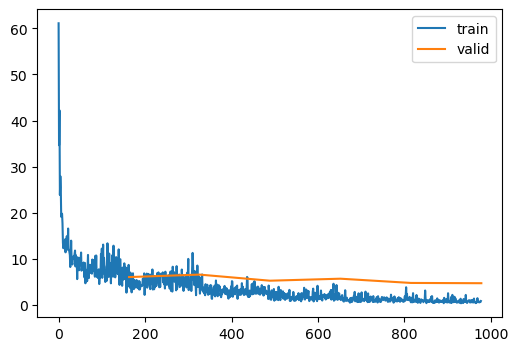

TimeR2Score,loss,epoch,train,time
0.782,10.195,0,True,00:06
0.857,6.351,0,False,00:01
0.887,5.167,1,True,00:05
0.871,6.042,1,False,00:01
0.926,3.312,2,True,00:05
0.890,5.113,2,False,00:01
0.955,1.979,3,True,00:05
0.899,4.737,3,False,00:01
0.973,1.193,4,True,00:05
0.901,4.595,4,False,00:01


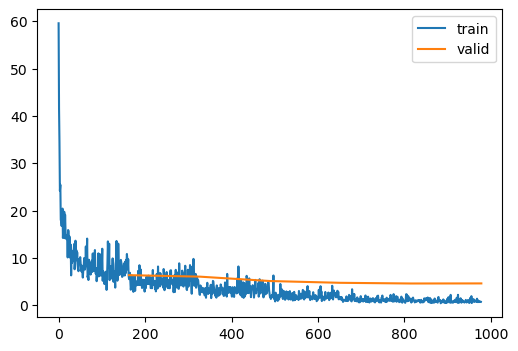

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.777,28.943,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.605,23.664,0,False,00:00


Inference on nascent
		preds, targs
tensor([[14.9687,  0.0000],
        [ 3.4111,  4.0000],
        [ 9.4300,  8.0000],
        [ 6.4985, 12.0000],
        [13.1818, 16.0000],
        [21.5937, 20.0000],
        [ 0.9915,  0.0000],
        [ 1.9961,  4.0000],
        [11.6710,  8.0000],
        [ 9.1239, 12.0000],
        [19.3555, 16.0000],
        [21.9849, 20.0000]])
result:  tensor(0.7024)


TimeR2Score,loss,epoch,train,time
0.684,14.919,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.748,11.884,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 1.5290,  1.0000],
        [ 6.8430,  4.0000],
        [ 6.1652,  7.0000],
        [ 9.7409, 10.0000],
        [12.7863, 13.0000],
        [ 6.4347, 16.0000],
        [20.5588, 19.0000],
        [22.7621, 22.0000]])
result:  tensor(0.7257)


TimeR2Score,loss,epoch,train,time
0.545,47.301,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.410,49.999,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.4258,  2.0000],
        [ 5.8047,  6.0000],
        [ 9.9795, 10.0000],
        [14.6933, 14.0000],
        [23.4257, 18.0000],
        [21.5865, 22.0000],
        [ 2.3500,  2.0000],
        [ 8.1702,  6.0000],
        [10.1706, 10.0000],
        [10.2254, 14.0000],
        [ 4.5756, 18.0000],
        [ 5.3584, 22.0000]])
result:  tensor(0.4889)


TimeR2Score,loss,epoch,train,time
0.675,144.425,0,False,00:03


TimeR2Score,loss,epoch,train,time
0.696,140.499,0,False,00:03


Inference on more
		preds, targs
tensor([[ 5.2262, 22.0000],
        [ 5.9105, 22.0000],
        [ 9.1584, 10.0000],
        ...,
        [22.4000, 19.5000],
        [14.9489,  7.5000],
        [16.6498, 13.5000]])
result:  tensor(0.6838)


In [63]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [64]:
preds.keys()

dict_keys(['nascent', 'gro', 'rna', 'more'])

In [67]:
df = pd.DataFrame(preds['more'], columns=['preds', 'targets'])
df

,preds,targets
0,5.226230,22.0
1,5.910467,22.0
2,9.158365,10.0
3,10.097108,18.0
4,9.182442,2.0
...,...,...
1091,14.802013,13.5
1092,19.269075,7.5
1093,22.400024,19.5
1094,14.948929,7.5


In [68]:
df.to_csv('preds_9482.csv')

In [63]:
torch.set_printoptions(edgeitems=15, linewidth=100)

Training models


TimeR2Score,loss,epoch,train,time
0.771,10.760,0,True,00:06
0.849,6.734,0,False,00:01


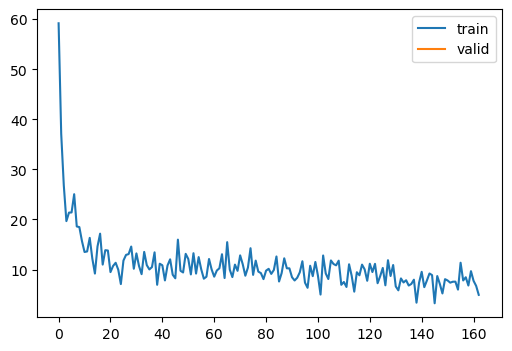

TimeR2Score,loss,epoch,train,time
0.774,10.736,0,True,00:07
0.852,6.643,0,False,00:01


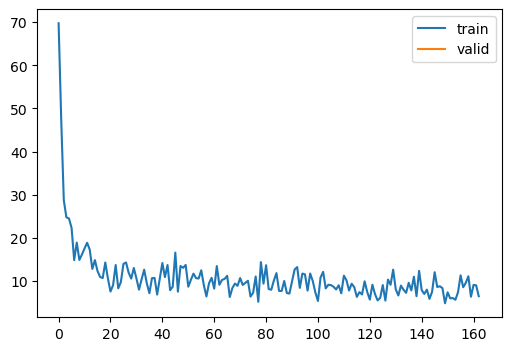

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.517,27.027,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.532,32.926,0,False,00:00


Inference on nascent
		preds, targs
tensor([[13.9479,  0.0000],
        [ 3.1151,  4.0000],
        [12.2396,  8.0000],
        [ 5.1389, 12.0000],
        [12.4784, 16.0000],
        [22.4060, 20.0000],
        [ 1.1477,  0.0000],
        [ 1.1355,  4.0000],
        [14.1972,  8.0000],
        [ 9.3857, 12.0000],
        [19.7294, 16.0000],
        [23.1241, 20.0000]])
result:  tensor(0.5295)


TimeR2Score,loss,epoch,train,time
0.558,20.891,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.630,24.108,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.9009,  1.0000],
        [ 6.9564,  4.0000],
        [ 7.1007,  7.0000],
        [10.1517, 10.0000],
        [13.3283, 13.0000],
        [ 3.6949, 16.0000],
        [21.9743, 19.0000],
        [20.8068, 22.0000]])
result:  tensor(0.5779)


TimeR2Score,loss,epoch,train,time
0.473,36.671,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.350,60.456,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.9873,  2.0000],
        [ 4.6267,  6.0000],
        [ 9.6859, 10.0000],
        [14.8856, 14.0000],
        [23.1716, 18.0000],
        [21.7847, 22.0000],
        [ 2.8924,  2.0000],
        [10.5423,  6.0000],
        [12.6655, 10.0000],
        [10.5984, 14.0000],
        [ 7.2441, 18.0000],
        [ 4.7737, 22.0000]])
result:  tensor(0.4428)


TimeR2Score,loss,epoch,train,time
0.684,132.771,0,False,00:05


TimeR2Score,loss,epoch,train,time
0.677,142.734,0,False,00:05


Inference on more
		preds, targs
tensor([[ 6.0791, 22.0000],
        [ 6.1594, 22.0000],
        [ 9.2075, 10.0000],
        [12.9036, 18.0000],
        [ 9.1739,  2.0000],
        [13.4108, 18.0000],
        [10.5875, 14.0000],
        [ 3.7824,  6.0000],
        [ 4.1267,  6.0000],
        [11.4954, 14.0000],
        [ 8.6984, 10.0000],
        [12.5296,  2.0000],
        [17.2509, 24.0000],
        [17.9406, 21.0000],
        [ 9.1039, 33.0000],
        ...,
        [15.7182,  7.5000],
        [21.0383,  1.5000],
        [15.7897, 16.5000],
        [21.6692,  4.5000],
        [20.1095, 22.5000],
        [17.2903, 16.5000],
        [22.1280,  1.5000],
        [14.6939, 10.5000],
        [17.7376, 16.5000],
        [21.8308,  1.5000],
        [14.1764, 13.5000],
        [14.5840,  7.5000],
        [20.8307, 19.5000],
        [13.4561,  7.5000],
        [15.4208, 13.5000]])
result:  tensor(0.6826)


{'nascent': tensor([[13.9479,  0.0000],
         [ 3.1151,  4.0000],
         [12.2396,  8.0000],
         [ 5.1389, 12.0000],
         [12.4784, 16.0000],
         [22.4060, 20.0000],
         [ 1.1477,  0.0000],
         [ 1.1355,  4.0000],
         [14.1972,  8.0000],
         [ 9.3857, 12.0000],
         [19.7294, 16.0000],
         [23.1241, 20.0000]]),
 'gro': tensor([[ 2.9009,  1.0000],
         [ 6.9564,  4.0000],
         [ 7.1007,  7.0000],
         [10.1517, 10.0000],
         [13.3283, 13.0000],
         [ 3.6949, 16.0000],
         [21.9743, 19.0000],
         [20.8068, 22.0000]]),
 'rna': tensor([[10.9873,  2.0000],
         [ 4.6267,  6.0000],
         [ 9.6859, 10.0000],
         [14.8856, 14.0000],
         [23.1716, 18.0000],
         [21.7847, 22.0000],
         [ 2.8924,  2.0000],
         [10.5423,  6.0000],
         [12.6655, 10.0000],
         [10.5984, 14.0000],
         [ 7.2441, 18.0000],
         [ 4.7737, 22.0000]]),
 'more': tensor([[ 6.0791, 22.0000],
    

In [64]:
lr, epochs = .3, 1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)